In [9]:
from stlayout.treemap import TreeMap
from stlayout.hierarchyUtils import clean_idle_nodes, set_nodes_height
from fa2 import ForceAtlas2
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
filename = 'celegansneural'

In [3]:
tree_map = TreeMap(f'./data/{filename}.vidi_r.json', 10, 10)
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=False)

In [4]:
clean_idle_nodes(tree_map.indexedNodes)
_, maxHeight = set_nodes_height(tree_map.indexedNodes, tree_map.root, tree_map.graph)
tree_map.build_hierarchy(maxHeight)
tree_map.find_links_in_super_nodes()

tree_map.construct_quotient_graph()
tree_map.layout_quotient_graphs(forceatlas2.forceatlas2_networkx_layout)

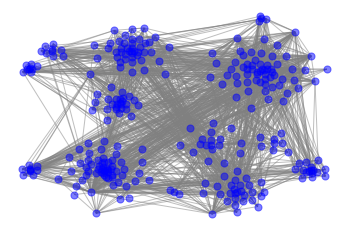

In [11]:
tree_map.treemap_layout(tree_map.root)
positions = tree_map.draw()


### 1) We can create the spherical projection

In [61]:
import numpy as np
posX = np.array([positions[i][0] for i in positions])
posY = np.array([positions[i][1] for i in positions])
maxX = posX.max()
minX = posX.min()
X_extent = maxX - minX
maxY = posY.max()
minY = posY.min()
Y_extent = maxY - minY
minY -= Y_extent * 0.15
Y_extent *= 1.3
# Clamp y to [0, Pi]
# Clamp x to [-pi, pi]
sPositions = {}
sx = []
sy = []
sz = []
for i, c in positions.items():
    x = 1.2 * (c[0] - minX) * np.pi / X_extent
    y = (c[1] - minY) * np.pi / Y_extent
    sx.append(np.sin(y) * np.cos(x))
    sy.append(np.sin(y) * np.sin(x))
    sz.append(np.cos(y))
    sPositions[i] = [sx[-1], sy[-1], sz[-1]]
    tree_map.indexedNodes[i]['pos3D'] = sPositions[i]
    tree_map.indexedNodes[i]['spherical3D'] = np.array([x, y])

def compute_super_node_pos3D(indexedNodes, nid):
    node = indexedNodes[nid]
    if not node['virtualNode']:
        return node['spherical3D']
    pos = np.zeros(2)
    for item in node['childIdx']:
        pos += compute_super_node_pos3D(indexedNodes, item)
    pos /= len(node['childIdx'])
    x = pos[0]
    y = pos[1]
    pos3D = np.array([np.sin(y) * np.cos(x), np.sin(y) * np.sin(x), np.cos(y)])
    node['pos3D'] = list((1 + 0.2 * node['height']) * (pos3D / np.linalg.norm(pos3D)))
    return pos

compute_super_node_pos3D(tree_map.indexedNodes, tree_map.root)
for i, n in tree_map.indexedNodes.items():
    if 'spherical3D' in n:
        del n['spherical3D']
    

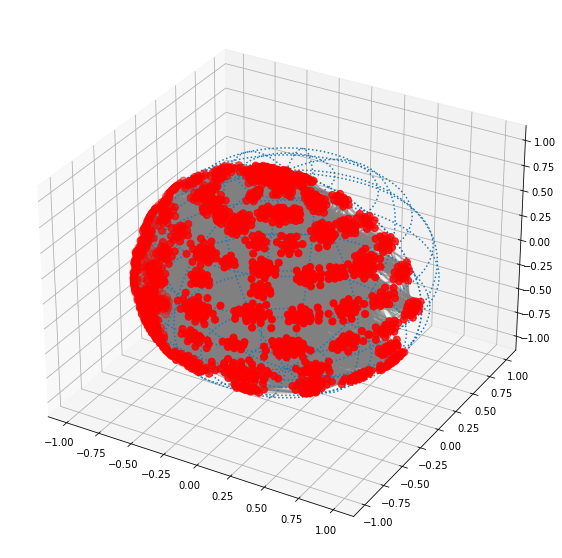

In [62]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(sx, sy, sz, c='r', s=50)

# center and radius
center = [0, 0, 0]
radius = 1

# data
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = radius * np.outer(np.cos(u), np.sin(v)) + center[0]
y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]

for e in tree_map.origin_graph.edges():
    p1 = sPositions[e[0]]
    p2 = sPositions[e[1]]
    ax.plot([p1[0],p2[0]],[p1[1], p2[1]],[p1[2], p2[2]],color = 'gray', alpha=0.5)

ax.plot_wireframe(x, y, z, rstride=10, cstride=10, linestyle=':')


In [63]:
tree_map.save_layout(f'./result/{filename}-layout.json')

### 2) Alternatively, we can flatten the layout

In [27]:
def flatten(positions):
    posX = np.array([positions[i][0] for i in positions])
    posY = np.array([positions[i][1] for i in positions])
    maxX = posX.max()
    minX = posX.min()
    maxY = posY.max()
    minY = posY.min()

    sPositions = {}
    for i, c in positions.items():
        x = (c[0] - minX) / (maxX - minX) 
        y = (c[1] - minY) / (maxY - minY)
        sPositions[i] = [x, y, 0]
        tree_map.indexedNodes[i]['pos3D'] = sPositions[i]

In [28]:
def compute_super_node_pos3D_flat(indexedNodes, nid):
    node = indexedNodes[nid]
    if not node['virtualNode']:
        return node['pos3D']
    pos = np.zeros(2)
    for item in node['childIdx']:
        pos += compute_super_node_pos3D_flat(indexedNodes, item)[:2]
    pos /= len(node['childIdx'])
    x = pos[0]
    y = pos[1]
    pos3D = np.array([x, y, 0])
    #node['pos3D'] = list((1 + 0.2 * node['height']) * (pos3D / np.linalg.norm(pos3D)))
    node['pos3D'] = list(pos3D)
    return pos

In [29]:
flatten(positions)
compute_super_node_pos3D_flat(tree_map.indexedNodes, tree_map.root)
tree_map.save_layout(f'./result/{filename}-layout.json-flat.json')